In [7]:
%pylab inline
import glob
import sys
import os
from collections import OrderedDict
import caffe
from DeepImageSynthesis.ImageSyn import *
from DeepImageSynthesis.Misc import *
from DeepImageSynthesis import LossFunctions
import Image
if 'mnet' not in locals():
    mnet = caffe.Net('/home/yeze/Desktop/ChineseCharPrj/caffeworks/modelzoo/mnist/mnist_test.prototxt','/home/yeze/Desktop/ChineseCharPrj/caffeworks/modelzoo/mnist/lenet_iter_10000.caffemodel',1)

Populating the interactive namespace from numpy and matplotlib


(28, 28, 1)
Image loaded!
Net loaded!
(1, 1, 256, 256)


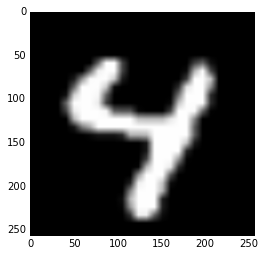

[256 256] (1, 1, 256, 256)


In [23]:
gpu = 0
caffe.set_mode_gpu() #for cpu mode do 'caffe.set_mode_cpu()'
caffe.set_device(gpu)

#Path parameters
#VGGweights = '/home/yeze/Documents/gitxivprojects/DeepTextures/Models/VGG_normalised.caffemodel'
#VGGmodel = '/home/yeze/Documents/gitxivprojects/DeepTextures/Models/VGG_ave_pool_deploy.prototxt'
VGGweights = '/home/yeze/Desktop/ChineseCharPrj/caffeworks/modelzoo/mnist/dst.caffemodel'
VGGmodel = '/home/yeze/Desktop/ChineseCharPrj/caffeworks/modelzoo/mnist/cut.prototxt'

#source_img_name = '/home/yeze/Desktop/ChineseCharPrj/caffeworks/data/fontsrc/heiti/heiti_1_7.jpg'
#source_img_name = 'Images/pebbles.jpg'
source_img_name = 'Images/mnist/1010_4.png'
srcimg = caffe.io.load_image(source_img_name)[:,:,1]
imshow(srcimg,cmap='gray')
srcimg = srcimg.reshape(28,28,1)
print srcimg.shape

imagenet_mean = numpy.array([ 0.40760392]) #mean for color channels (bgr)

#load source image
im_size = 256.
source_img, net = load_resources(srcimg, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)
im_size = asarray(source_img.shape[-2:])
print im_size, source_img.shape

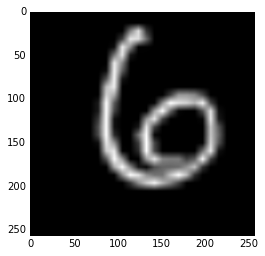

In [24]:
initpicname = 'Images/mnist/100_6.png'
initpic = caffe.io.load_image(initpicname)[:,:,[0]]
initpic = net.transformer.preprocess('data', initpic)
imshow(initpic[0], cmap='gray')

#define layers to include in the texture model and weights w_l
#tex_layers = ['pool2', 'pool1','conv1_1','conv3_1', 'pool3']
tex_layers = ['pool2', 'pool1','conv1']
tex_weights = [1e9, 2e9, 5e9]
#tex_weights = [1e9 for i in tex_layers]

#pass image through the network and save the constraints on each layer
constraints = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                      'weight': tex_weights[l]}])
#get optimisation bounds
bounds = get_bounds([source_img],im_size)

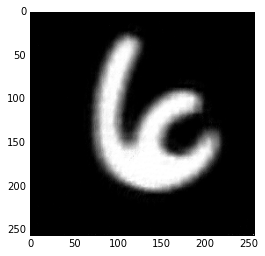

loss=74404549432.4,False
IF_MASK:{0}


In [25]:
#l-bfgs parameters optimisation
maxiter = 300
m = 10

#generate new texture
result = ImageSyn(net, constraints,init=initpic, bounds=bounds,
                  callback=lambda x: show_progress(x,net,dname='./256s/',CLC=True, IF_SAVE=True), 
                  minimize_options={'maxiter': maxiter,
                                    'maxcor': m,
                                    'ftol': 0, 'gtol': 0})

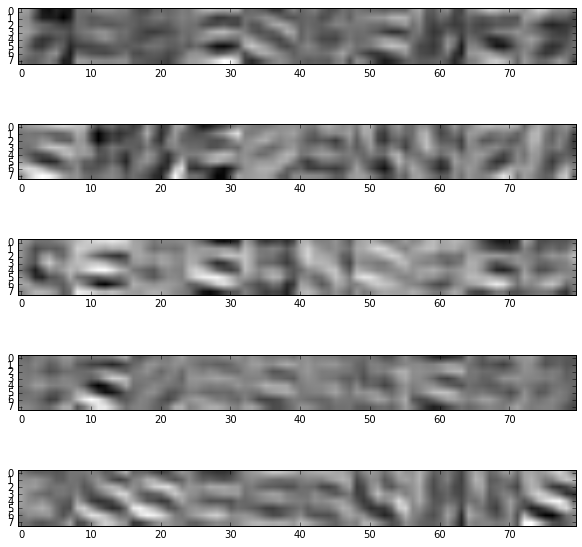

In [13]:
showFeatureMap(net=net, data=source_img, layer='conv2')

(28, 28)
{'ip2': array([[-1754.7244873 ,  -447.12020874,  1003.22515869,  3937.75      ,
        -1824.0345459 ,  1043.30725098, -1087.31738281,  -550.66101074,
          130.50814819, -1057.97717285]], dtype=float32), 'loss': array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)}
Prediction=3


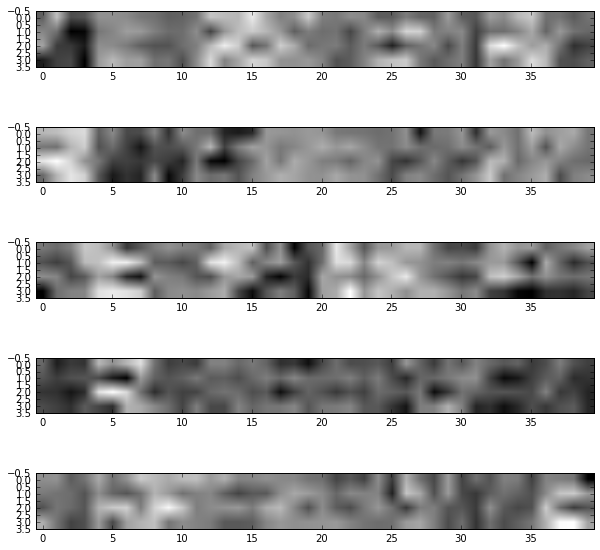

In [14]:
x = result['x'].reshape(im_size[0],im_size[1])
x = asarray((x-x.min()), uint8)
print x.shape
showFeatureMap(net=net, data=x[None,None,:,:], layer='pool2')
prediction = 'nil'
if x.shape[0] == 28:
    ret = mnet.forward(data=x.reshape(1,1,28,28),blobs=['ip2'])
    print ret
    prediction = list(ret['loss'][0]).index(1.)
    print 'Prediction={}'.format(prediction)

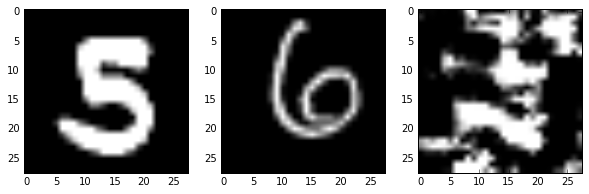

In [15]:
rcParams['figure.figsize'] = (10,10)
fg = figure()
fg.add_subplot(1,3,1).imshow(srcimg[:,:,0],cmap='gray')
fg.add_subplot(1,3,2).imshow(initpic[0,:,:],cmap='gray')
fg.add_subplot(1,3,3).imshow(x,cmap='gray')

In [8]:
dname = '/home/yeze/Desktop/ChineseCharPrj/caffeworks/modelzoo/mnist/log/resultsave/'
fname = dname + 'exp7_1_c{}.png'.format(prediction)
Image.fromarray(x).save(fname)

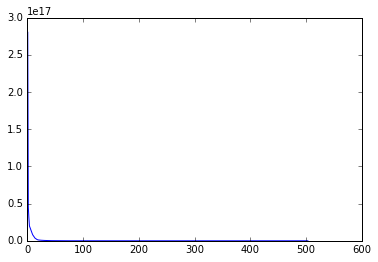

In [17]:
plot(getLossList())

In [9]:
type(x)

numpy.ndarray